<a href="https://colab.research.google.com/github/kristinazk/HomeWorkWeek17/blob/main/adversarialHomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


# Training the GAN
### Gone Wrong

The GAN was trained via a huge number of ways: first by trying the initial setup of n = 5. Then, after not obtaining the desired results the strategy was changed but in vain. The next thing was to try to change the learning rates of the optimizers. After that, I tried different activation functions (such as leaky ReLu, ReLu, etc).

The main problem is that the initial loss of the discriminator is too small, (close to 0,6) and the discriminator is too powerful. Most of the time the loss of the generator remained unchanged or changed by an insignificant amount. In order to prevent exploding and vanishing gradients I applied BatchNorm layers. Additionally, to prevent overfitting I also applied dropout layers to the discriminator but norhing helped.

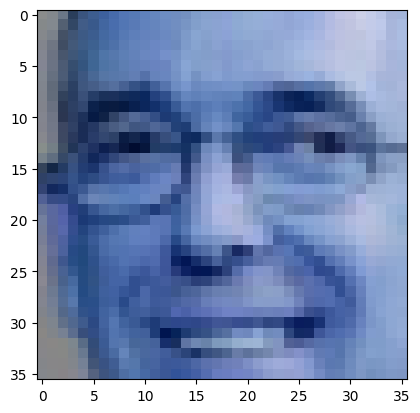

In [3]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [5]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE], name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8, 8, 10)))
generator.add(L.Conv2DTranspose(64, kernel_size=(5, 5), activation='elu'))

generator.add(L.Conv2DTranspose(64, kernel_size=(5, 5), activation='elu'))

generator.add(L.UpSampling2D(size=(2, 2)))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))

generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))

generator.add(L.Conv2D(3, kernel_size=3, activation=None))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       16064     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       102464    
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [6]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [7]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(64, kernel_size=3, activation='elu'))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(128, kernel_size=3, activation='elu'))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

In [8]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow, ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

1/1 [==============================] - 0s 474ms/step


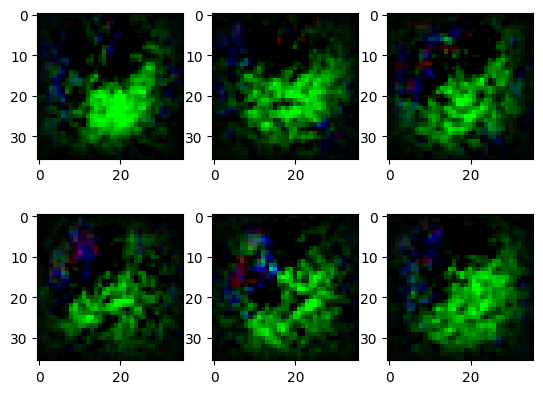

32/32 [==============================] - 1s 25ms/step


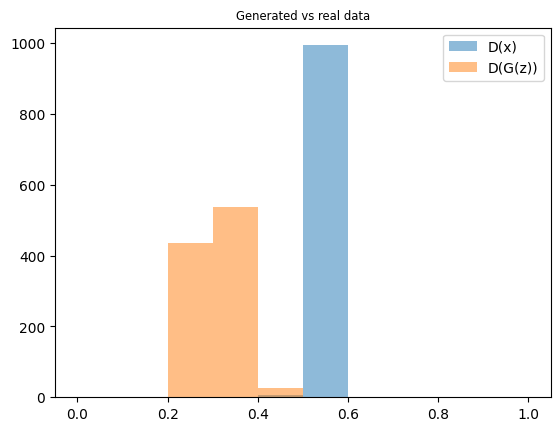

1
Discriminator loss:  tf.Tensor(0.33165237, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.33119944, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.330747, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.3302949, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-0.7821002, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-0.9681568, shape=(), dtype=float32)
2
Discriminator loss:  tf.Tensor(0.49460414, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.49409568, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.4935876, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.49307972, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-1.0810316, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-1.2579834, shape=(), dtype=float32)
3
Discriminator loss:  tf.Tensor(0.5764122, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.57588065, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.5753496, shape=(), dtype=float

In [ ]:
from IPython import display
from tqdm import tnrange

disc_optimizer = tf.optimizers.SGD(learning_rate=1e-5)
gen_optimizer = tf.optimizers.Adam(learning_rate=1e-3)


for epoch in tnrange(50000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    print(epoch)

    if epoch < 1000:
      n = 4
    elif 5000 > epoch >= 1000:
      n = 3
    elif 38000 > epoch >= 5000:
      n = 2
    else:
      n = 1

    ########################
    # discriminator training
    ########################
    for _ in range(n):
        with tf.GradientTape() as disc_tape:
            logp_real = (discriminator(real_data))

            generated_data = generator(noise)

            logp_gen = tf.math.log(1 - discriminator(generated_data))

            d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])

            # regularize
            d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

        # optimize
        disc_optimizer.minimize(
          d_loss,
          var_list=discriminator.trainable_variables,
          tape=disc_tape
    )
        print("Discriminator loss: ", d_loss)

    ########################
    # generator training
    ########################
    m = 1
    if d_loss < 0.5:
      m = 2

    for _ in range(m):
      with tf.GradientTape() as gen_tape:
          logp_gen = tf.math.log(1 - discriminator(generator(noise)))

          g_loss = -tf.reduce_mean(logp_gen[:, 1])

      # optimize
      gen_optimizer.minimize(
          g_loss,
          var_list=generator.trainable_variables,
          tape=gen_tape
      )
      print("Generator loss: ", g_loss)

    if epoch % 100 == 0:
        display.clear_output(wait=True)
        sample_images(2, 3, True)
        sample_probas(1000)

# The final result after 50.000 iterations


4/4 [==============================] - 0s 3ms/step


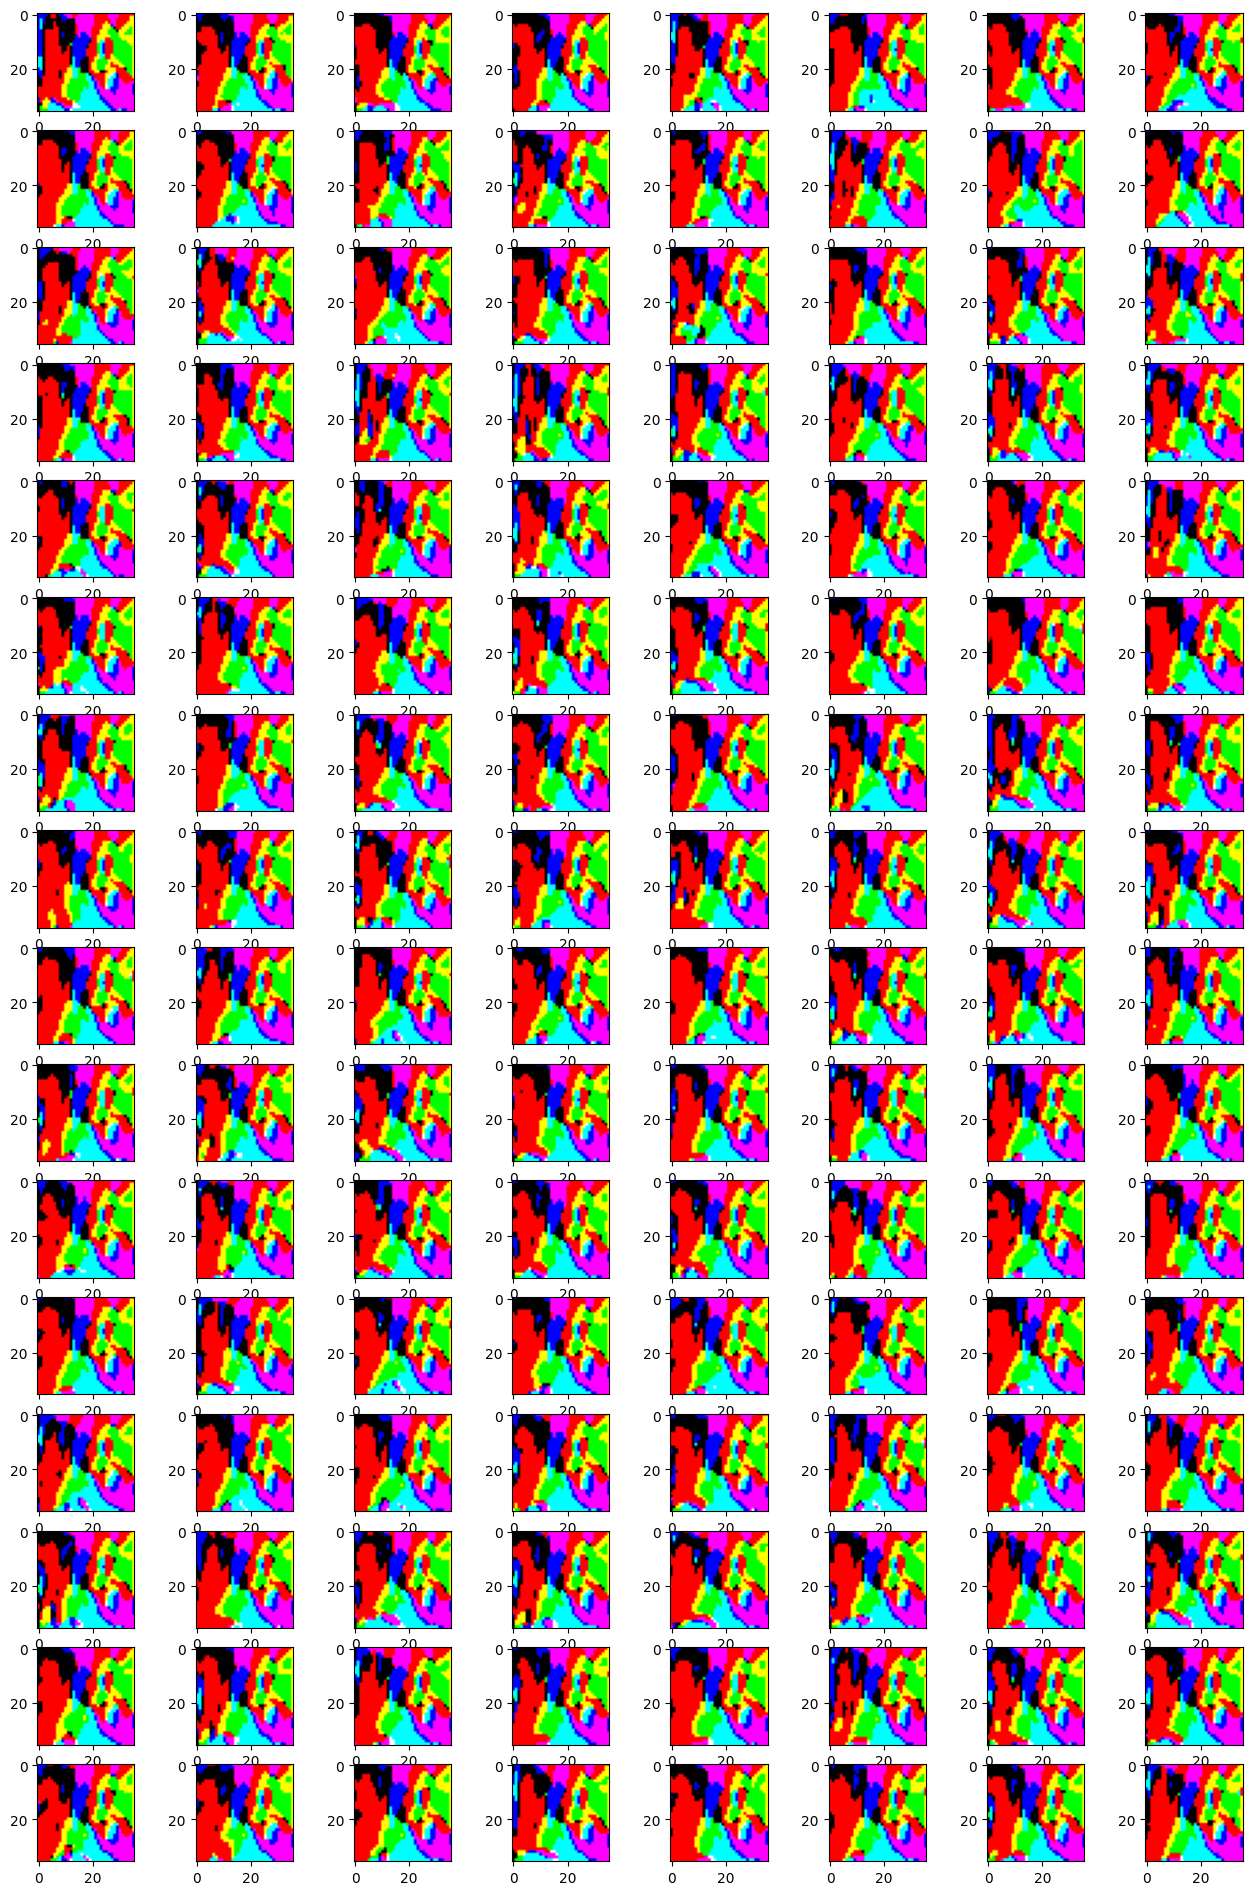

In [10]:
plt.figure(figsize=[16,24])
sample_images(16,8)